## What is Lasso Regression?

### Lasso Regression **(Least Absolute Shrinkage and Selection Operator)** is a regularized version of Linear Regression that uses **L1 regularization**. Unlike Ridge Regression which uses the sum of squared weights, Lasso uses the sum of absolute values of weights.


### The Cost Function

Lasso Regression Cost Function:

`J(θ) = MSE(θ) + α × ∑|θᵢ|   for i = 1 to n`

Where:

- MSE(θ): Mean Squared Error
- α: Regularization strength
- ∑|θᵢ|: Sum of absolute values of weights (L1 norm)

**Key Difference from Ridge Regression**

- Ridge (L2): `α × ∑θᵢ²` - Shrinks weights evenly, never to exactly zero
- Lasso (L1): `α × ∑|θᵢ|` - Can force weights to become exactly zero (feature selection)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

np.random.seed(42)
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

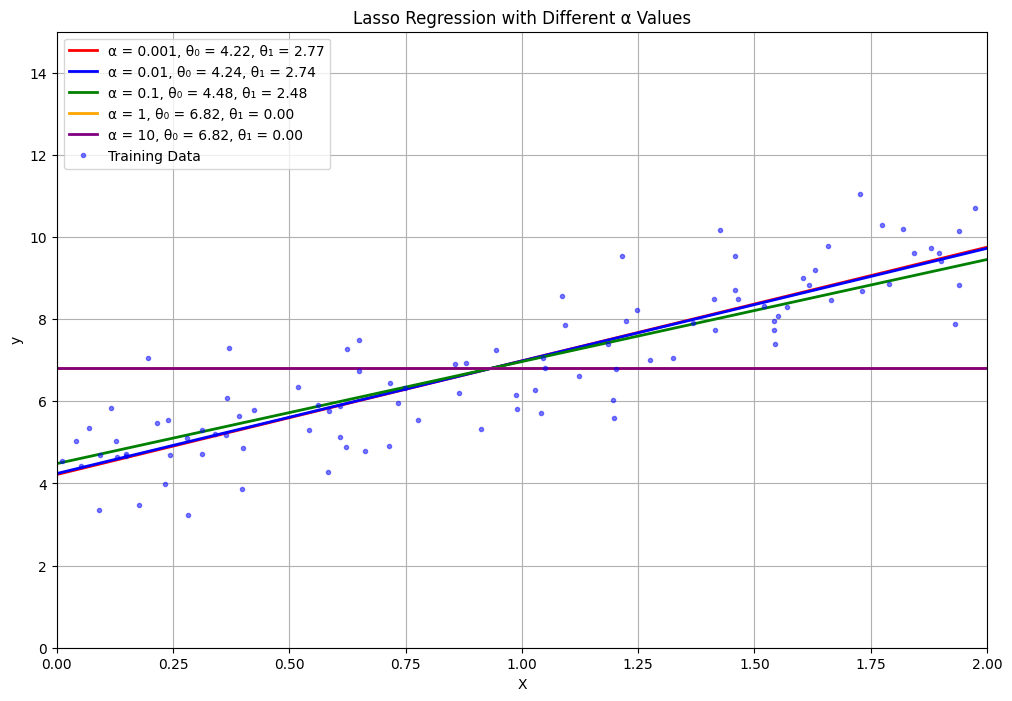

In [3]:
alphas = [0.001, 0.01, 0.1, 1, 10]
colors = ["red", "blue", "green", "orange", "purple"]

plt.figure(figsize=(12, 8))

for alpha, color in zip(alphas, colors):
    lasso_reg = Lasso(alpha=alpha)
    lasso_reg.fit(X, y.ravel())  # lasso expects 1D y

    # make predictions
    X_new = np.linspace(0, 2, 100).reshape(-1, 1)
    y_new = lasso_reg.predict(X_new)

    plt.plot(
        X_new,
        y_new,
        color,
        linewidth=2,
        label=f"α = {alpha}, θ₀ = {lasso_reg.intercept_:.2f}, "
        f"θ₁ = {lasso_reg.coef_[0]:.2f}",
    )

plt.plot(X, y, "b.", alpha=0.5, label="Training Data")
plt.xlabel("X")
plt.ylabel("y")
plt.title("Lasso Regression with Different α Values")
plt.legend(loc="upper left")
plt.grid(True)
plt.axis([0, 2, 0, 15])
plt.show()

In [5]:
# feature selection example

np.random.seed(42)
X_multi = np.random.randn(100, 5)  # 5 features
# Only first 2 features are actually important
y_multi = 2 + 3 * X_multi[:, 0] + 1.5 * X_multi[:, 1] + np.random.randn(100)

# Compare Lasso vs Ridge
lasso = Lasso(alpha=0.1)
ridge = Ridge(alpha=0.1)

lasso.fit(X_multi, y_multi)
ridge.fit(X_multi, y_multi)

print("Feature weights comparison:")
print("Feature\t\tLasso\t\tRidge")
print("-" * 40)
for i in range(5):
    print(f"Feature {i}\t{lasso.coef_[i]:.4f}\t\t{ridge.coef_[i]:.4f}")

print(f"\nBias (θ₀):")
print(f"Lasso: {lasso.intercept_:.4f}")
print(f"Ridge: {ridge.intercept_:.4f}")

Feature weights comparison:
Feature		Lasso		Ridge
----------------------------------------
Feature 0	2.8939		3.0499
Feature 1	1.5087		1.6331
Feature 2	0.0000		-0.0208
Feature 3	0.0404		0.1603
Feature 4	-0.0000		-0.0076

Bias (θ₀):
Lasso: 1.8741
Ridge: 1.8540


- Notice how Lasso sets the weights of irrelevant features (2, 4) to exactly zero!


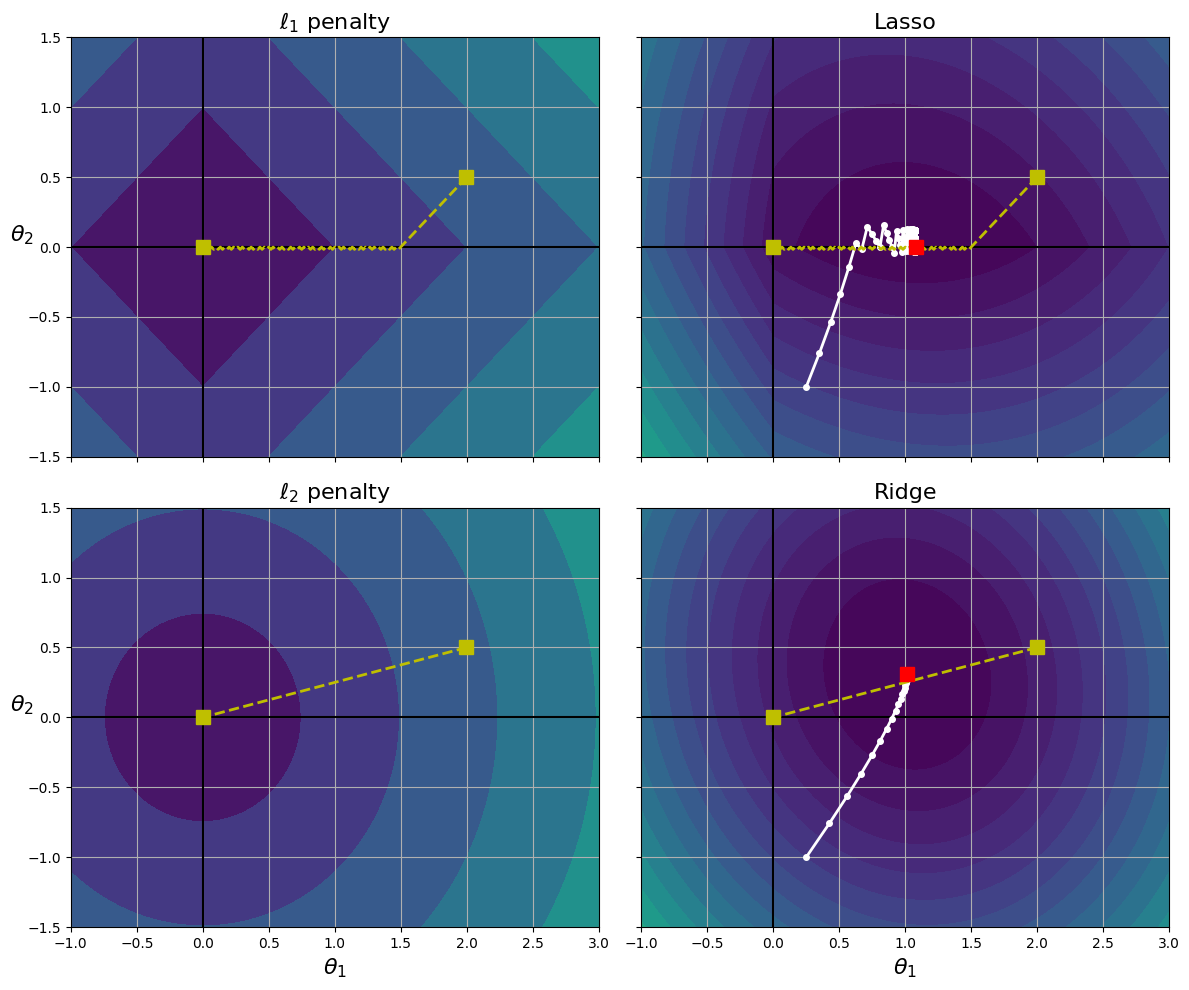

In [7]:
# understanding the comparision code

t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5
t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]

# create simple dataset
Xr = np.array([[1, 1], [1, -1], [1, 0.5]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

# calc MSE cost
J = (1 / len(Xr) * np.sum((T.dot(Xr.T) - yr.T) ** 2, axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(
    t1.shape
)  # L1 norm (sum of absolute values)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(
    t1.shape
)  # L2 norm (square root of sum of squares)

# find minimum of MSE
t_min_idx = np.unravel_index(np.argmin(J), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]


# gradient descent path function
def bgd_path(theta, X, y, l1, l2, core=1, eta=0.05, n_iterations=200):
    path = [theta]
    for iteration in range(n_iterations):
        # calc gradients: MSE gradient + L1 penalty + L2 penalty
        gradients = (
            core * 2 / len(X) * X.T.dot(X.dot(theta) - y)
            + l1 * np.sign(theta)
            + l2 * theta
        )
        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)


# comparision plot
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12, 10))

for i, N, l1, l2, title in ((0, N1, 2.0, 0, "Lasso"), (1, N2, 0, 2.0, "Ridge")):
    # Total cost = MSE + regularization
    JR = J + l1 * N1 + l2 * 0.5 * N2**2

    # Find minimum of regularized cost
    tr_min_idx = np.unravel_index(np.argmin(JR), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    t_init = np.array([[0.25], [-1]])

    # Create contour levels
    levelsJ = (np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(J) - np.min(J)) + np.min(J)
    levelsJR = (np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(JR) - np.min(JR)) + np.min(
        JR
    )
    levelsN = np.linspace(0, np.max(N), 10)

    # Calculate optimization paths
    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)  # No regularization
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)  # With regularization
    path_N = bgd_path(
        np.array([[2.0], [0.5]]), Xr, yr, np.sign(l1) / 3, np.sign(l2), core=0
    )

    # Left column: Penalty functions
    ax = axes[i, 0]
    ax.grid(True)
    ax.axhline(y=0, color="k")
    ax.axvline(x=0, color="k")
    ax.contourf(t1, t2, N / 2.0, levels=levelsN)
    ax.plot(path_N[:, 0], path_N[:, 1], "y--", linewidth=2)
    ax.plot(0, 0, "ys", markersize=10)  # Origin
    ax.plot(t1_min, t2_min, "ys", markersize=10)  # MSE minimum
    ax.set_title(r"$\ell_{}$ penalty".format(i + 1), fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)
    ax.set_ylabel(r"$\theta_2$", fontsize=16, rotation=0)

    # Right column: Total cost function
    ax = axes[i, 1]
    ax.grid(True)
    ax.axhline(y=0, color="k")
    ax.axvline(x=0, color="k")
    ax.contourf(t1, t2, JR, levels=levelsJR)
    ax.plot(
        path_JR[:, 0], path_JR[:, 1], "w-o", linewidth=2, markersize=4
    )  # Regularized path
    ax.plot(path_N[:, 0], path_N[:, 1], "y--", linewidth=2)  # Penalty path
    ax.plot(0, 0, "ys", markersize=10)  # Origin
    ax.plot(t1_min, t2_min, "ys", markersize=10)  # MSE minimum
    ax.plot(t1r_min, t2r_min, "rs", markersize=10)  # Regularized minimum
    ax.set_title(title, fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)

plt.tight_layout()
plt.show()

### Key Insights from the Visualization

1. L1 Penalty (Left-top): Diamond-shaped contours - encourages sparsity
2. L2 Penalty (Left-bottom): Circular contours - encourages small but non-zero weights
3. Lasso Optimization (Right-top): Path quickly hits the axis (θ₂ = 0), then moves along it
4. Ridge Optimization (Right-bottom): Smooth path toward the origin

### When to Use Lasso vs Ridge

Use Lasso When:

- You have many features and suspect only few are important
- You want automatic feature selection
- Interpretability is important (seeing which features matter)
- You're willing to potentially lose some predictive power for simplicity

Use Ridge When:

- All features are potentially relevant
- You want to keep all features but reduce their impact
- Features are correlated with each other
- You want more stable predictions
